# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

%load_ext autoreload
%autoreload 2

# Load irradiance data

## SNL

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
cols = ['Global_Wm2', 'Date-Time']
rtc_data = pd.read_csv(file, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
rtc_data.index = rtc_data.index.tz_localize('Etc/GMT+7')
rtc_data = rtc_data.reindex(
    pd.date_range(start=rtc_data.index[0], end=rtc_data.index[-1], freq='1min')
).fillna(0)
rtc_data = pd.Series(rtc_data['Global_Wm2'], index=rtc_data.index)
rtc_data[rtc_data < 0] = 0

## NREL SRRL BMS

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/.  This data is being used because it was already downloaded for a different notebook.  Irradiance data is also measured on a minute-to-minute basis.

In [3]:
srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
srrl_data = pd.read_csv(srrl_file)
srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
srrl_data = srrl_data.reindex(
    pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
).fillna(0)
srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
srrl_data[srrl_data < 0] = 0

# Set up PVLib system

## SNL

In [4]:
rtc_azimuth = 180
rtc_elevation = 1658
rtc_tilt = 35
rtc_lat = 35.0549
rtc_lon = -106.5433

In [5]:
rtc_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=rtc_tilt, surface_azimuth=rtc_azimuth)
rtc_loc = pvlib.location.Location(rtc_lat, rtc_lon, altitude=rtc_elevation)
rtc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=rtc_no_loc, location=rtc_loc)

## NREL SRRL BMS

In [6]:
srrl_lat = 39.742
srrl_lon = -105.18
srrl_tilt = 40
srrl_azimuth = 180
srrl_elevation = 1828.8

In [7]:
srrl_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=srrl_tilt, surface_azimuth=srrl_azimuth)
srrl_loc = pvlib.location.Location(srrl_lat, srrl_lon, altitude=srrl_elevation)
srrl = pvlib.pvsystem.LocalizedPVSystem(pvsystem=srrl_no_loc, location=srrl_loc)

# Analysis

In [8]:
def pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 5))

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear & ~pvlib_is_clear], sample[is_clear & ~pvlib_is_clear], 
               facecolor='none', edgecolor='green', label='model free')
    _ = ax.scatter(sample.index[pvlib_is_clear & ~is_clear], sample[pvlib_is_clear & ~is_clear], 
               facecolor='none', edgecolor='red', label='pvlib')
    _ = ax.scatter(sample.index[pvlib_is_clear & is_clear], sample[is_clear & pvlib_is_clear], 
               facecolor='none', edgecolor='yellow', label='both')
    _ = ax.legend()
    
    ax = axes[1]
    _ = ax.plot(is_clear.index, np.cumsum(is_clear.astype(int)), label='model free')
    _ = ax.plot(pvlib_is_clear.index, np.cumsum(pvlib_is_clear.astype(int)), label='pvlib')
    _ = ax.legend()
    
    fig.tight_layout()

## Samples from SNL

In [9]:
rtc_sample = rtc_data[(rtc_data.index >= '2016-07-01') & (rtc_data.index < '2016-07-08')]

In [10]:
rtc_clear_skies = rtc.get_clearsky(rtc_sample.index)
rtc_clear_skies = rtc_clear_skies['ghi']

Get pvlib clear sky times for comparison using standard/default parameters.

In [11]:
rtc_pvlib_is_clear = pvlib.clearsky.detect_clearsky(rtc_sample, rtc_clear_skies, rtc_sample.index, 10)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


### Standard method

In [12]:
rtc_mf_is_clear, rtc_result = clearsky_detect_model_free.model_free_detect(rtc_sample, window=240, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:55: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


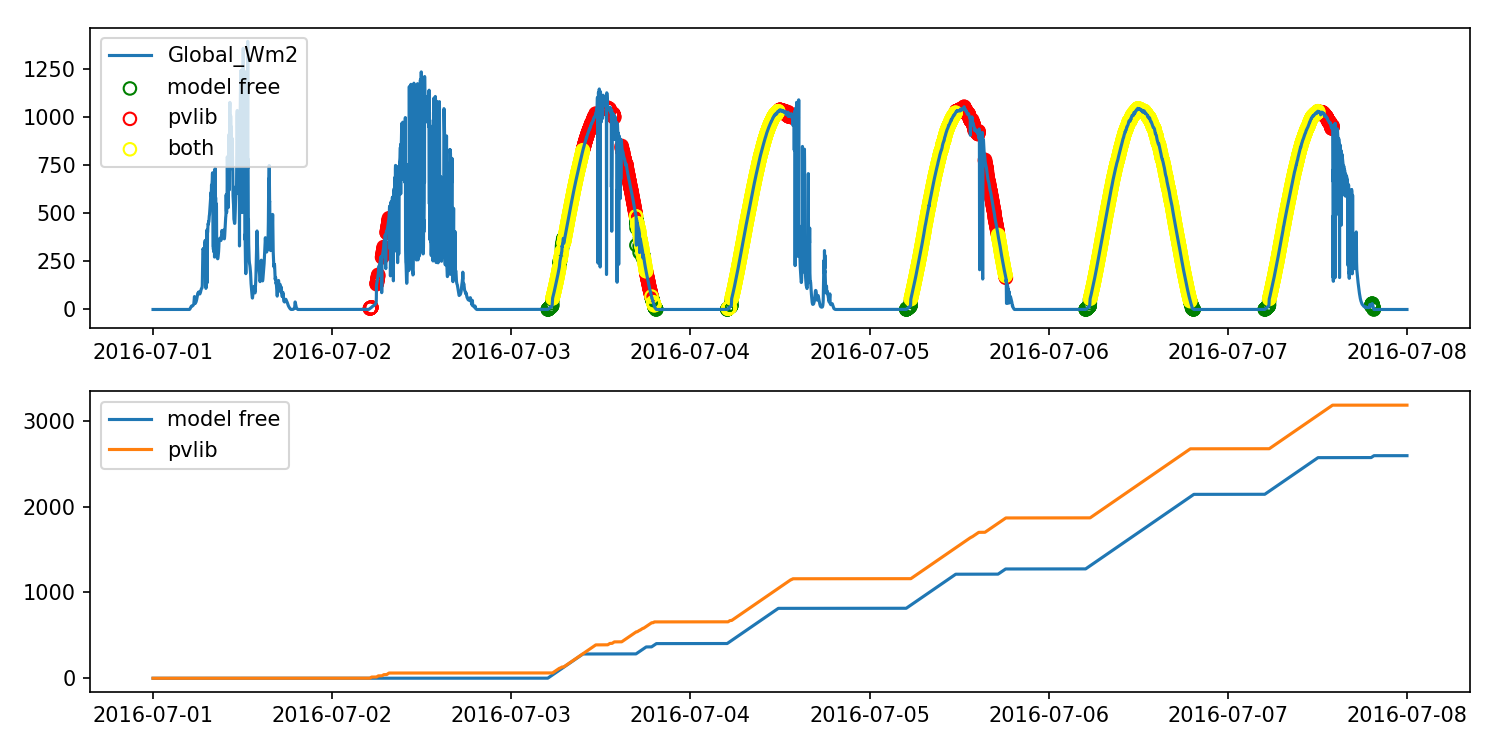

In [13]:
pvlib_compare_plot(rtc_sample, rtc_clear_skies, rtc_mf_is_clear, rtc_pvlib_is_clear)

The standard model-free based approach is more generous than PVLib methods.  The model-free approach also fails at some fairly obvious locations (July 1st mid-late day, July 4th late day).

### Democratic method

In [14]:
rtc_mf_is_clear, rtc_result = clearsky_detect_model_free.model_free_detect_democratic(rtc_sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:99: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances.values) / np.log(integrals.values), index=data.index)
/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:277: RuntimeWarning: invalid value encountered in less_equal
  pct = np.sum((array <= metric_tol).astype(int)) / len(array)


<IPython.core.display.Javascript object>


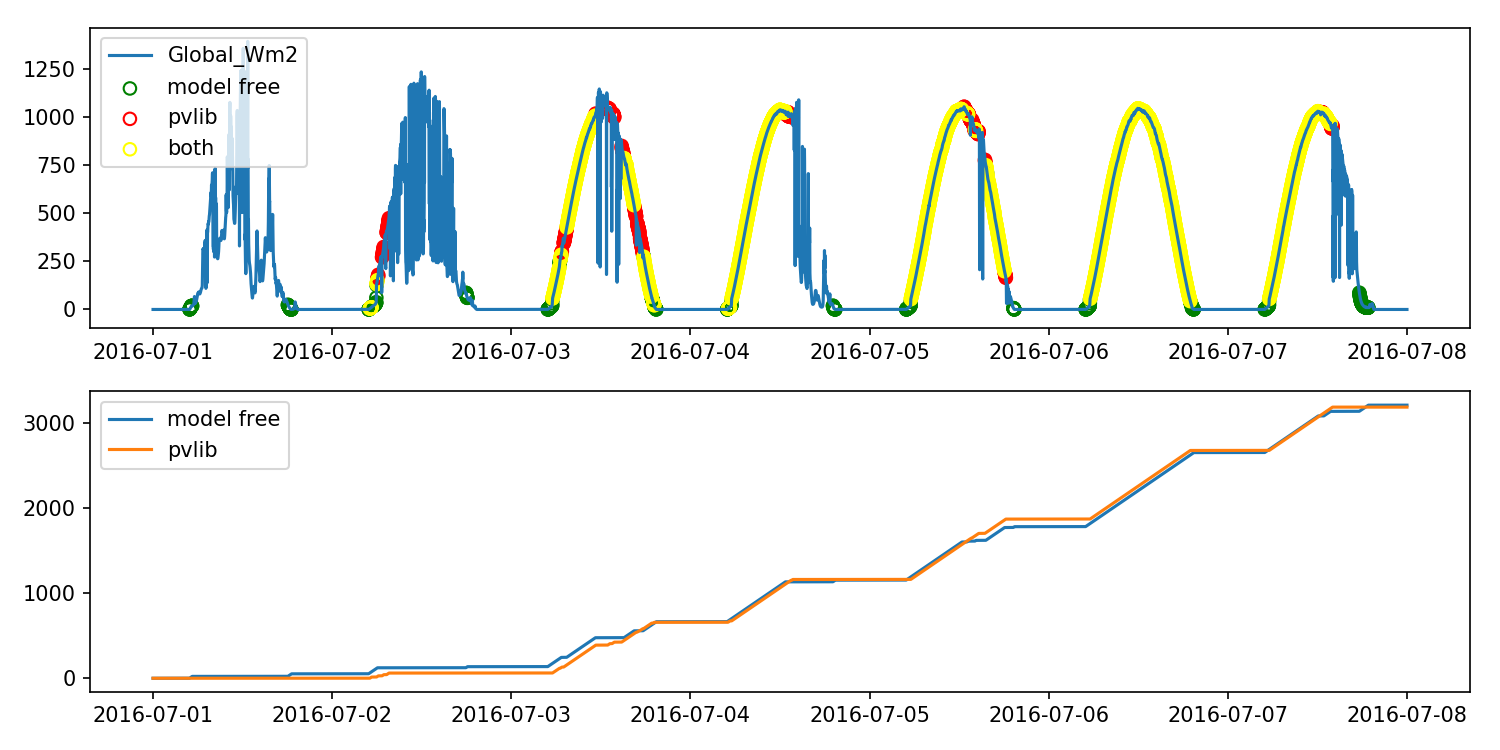

In [15]:
pvlib_compare_plot(rtc_sample, rtc_clear_skies, rtc_mf_is_clear, rtc_pvlib_is_clear)

The democratic method performs very similarly to PVLib over the course of the week.  The model-free method here is friendlier to early morning and late nights.

### Mean method

In [16]:
rtc_mf_is_clear, rtc_result = clearsky_detect_model_free.model_free_detect_meanval(rtc_sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:147: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances.values) / np.log(integrals.values), index=data.index)
/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:155: RuntimeWarning: invalid value encountered in less_equal
  is_clear.iloc[midpoints] = (means <= metric_tol) & (data[midpoints] > 0.0)


<IPython.core.display.Javascript object>


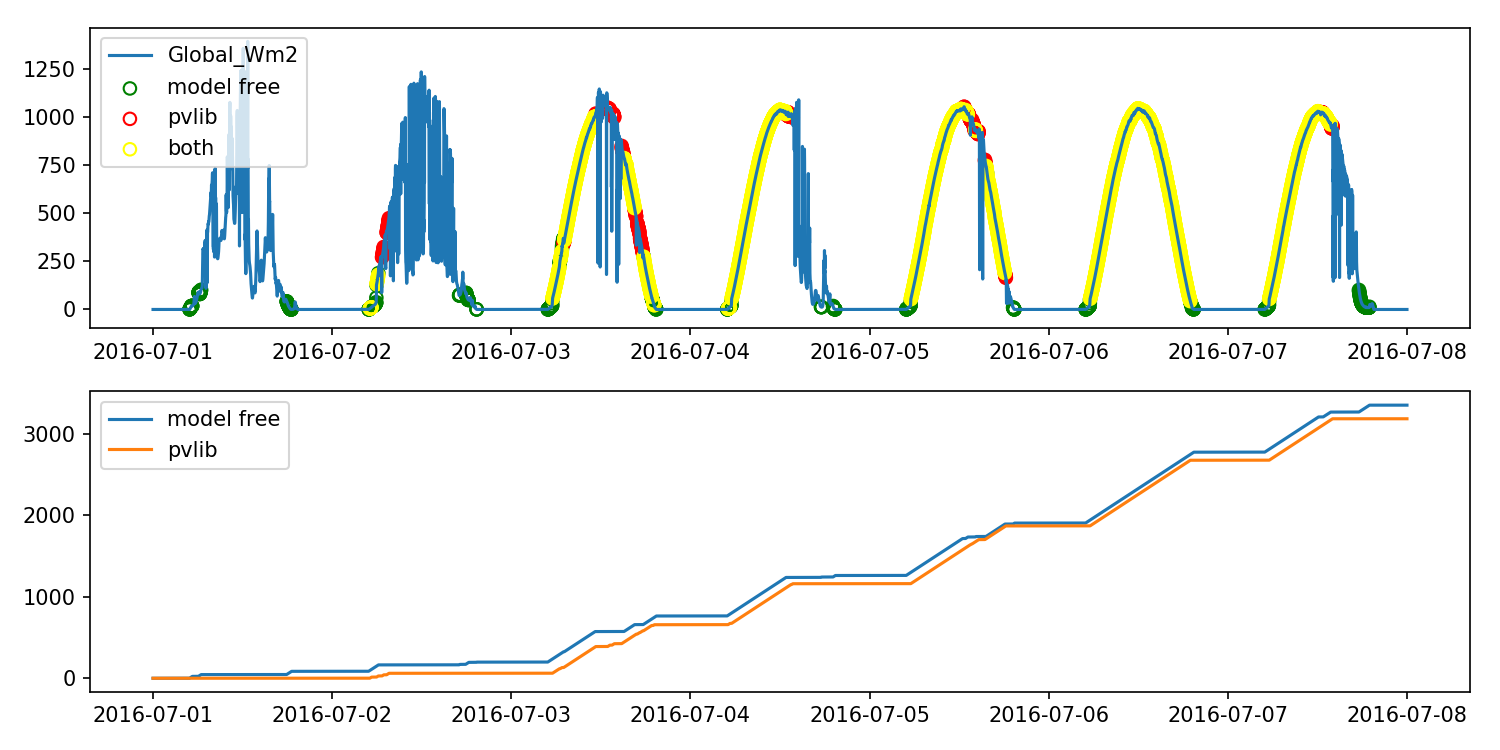

In [17]:
pvlib_compare_plot(rtc_sample, rtc_clear_skies, rtc_mf_is_clear, rtc_pvlib_is_clear)

## Samples from NREL SRRL BMS

In [18]:
srrl_sample = srrl_data[(srrl_data.index >= '2014-01-01') & (srrl_data.index < '2014-01-08')]

In [19]:
srrl_clear_skies = srrl.get_clearsky(srrl_sample.index)
srrl_clear_skies = srrl_clear_skies['ghi']

In [20]:
cs_srrl_is_clear, cs_srrl_result = clearsky_detect_model_free.model_free_detect(srrl_clear_skies, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:55: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


Get pvlib clear sky times for comparison using standard/default parameters.

In [21]:
srrl_pvlib_is_clear = pvlib.clearsky.detect_clearsky(srrl_sample, srrl_clear_skies, srrl_sample.index, 10)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


### Standard method

In [22]:
srrl_mf_is_clear, srrl_result = clearsky_detect_model_free.model_free_detect(srrl_sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:55: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


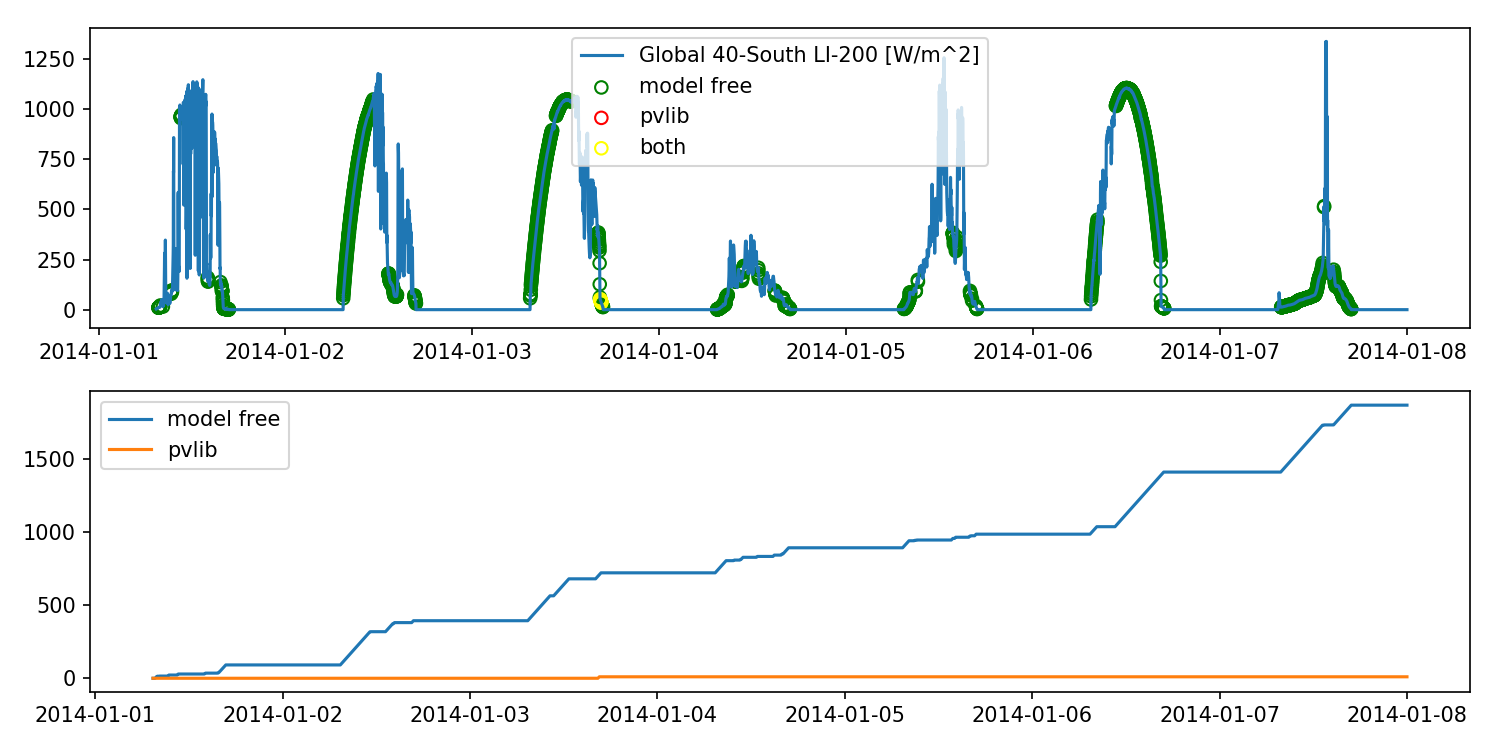

In [23]:
pvlib_compare_plot(srrl_sample, srrl_clear_skies, srrl_mf_is_clear, srrl_pvlib_is_clear)

The standard model-free based approach is more generous than PVLib methods.  The model-free approach also fails at some fairly obvious locations (July 1st mid-late day, July 4th late day).

### Democratic method

In [24]:
srrl_mf_is_clear, srrl_result = clearsky_detect_model_free.model_free_detect_democratic(srrl_sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:99: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances.values) / np.log(integrals.values), index=data.index)
/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:277: RuntimeWarning: invalid value encountered in less_equal
  pct = np.sum((array <= metric_tol).astype(int)) / len(array)


<IPython.core.display.Javascript object>


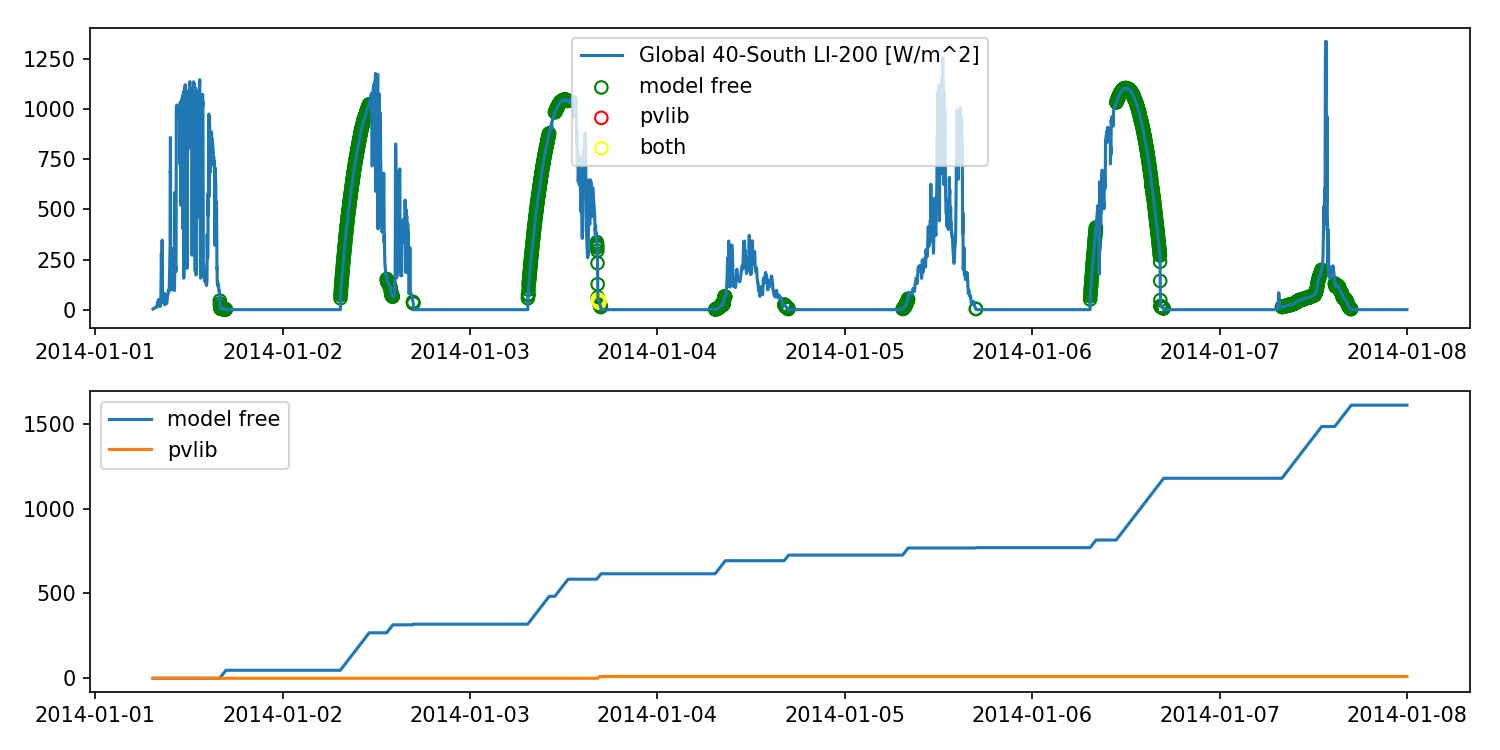

In [25]:
pvlib_compare_plot(srrl_sample, srrl_clear_skies, srrl_mf_is_clear, srrl_pvlib_is_clear)

### Mean method

In [26]:
srrl_mf_is_clear, srrl_result = clearsky_detect_model_free.model_free_detect_meanval(srrl_sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:147: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances.values) / np.log(integrals.values), index=data.index)
/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:155: RuntimeWarning: invalid value encountered in less_equal
  is_clear.iloc[midpoints] = (means <= metric_tol) & (data[midpoints] > 0.0)


<IPython.core.display.Javascript object>


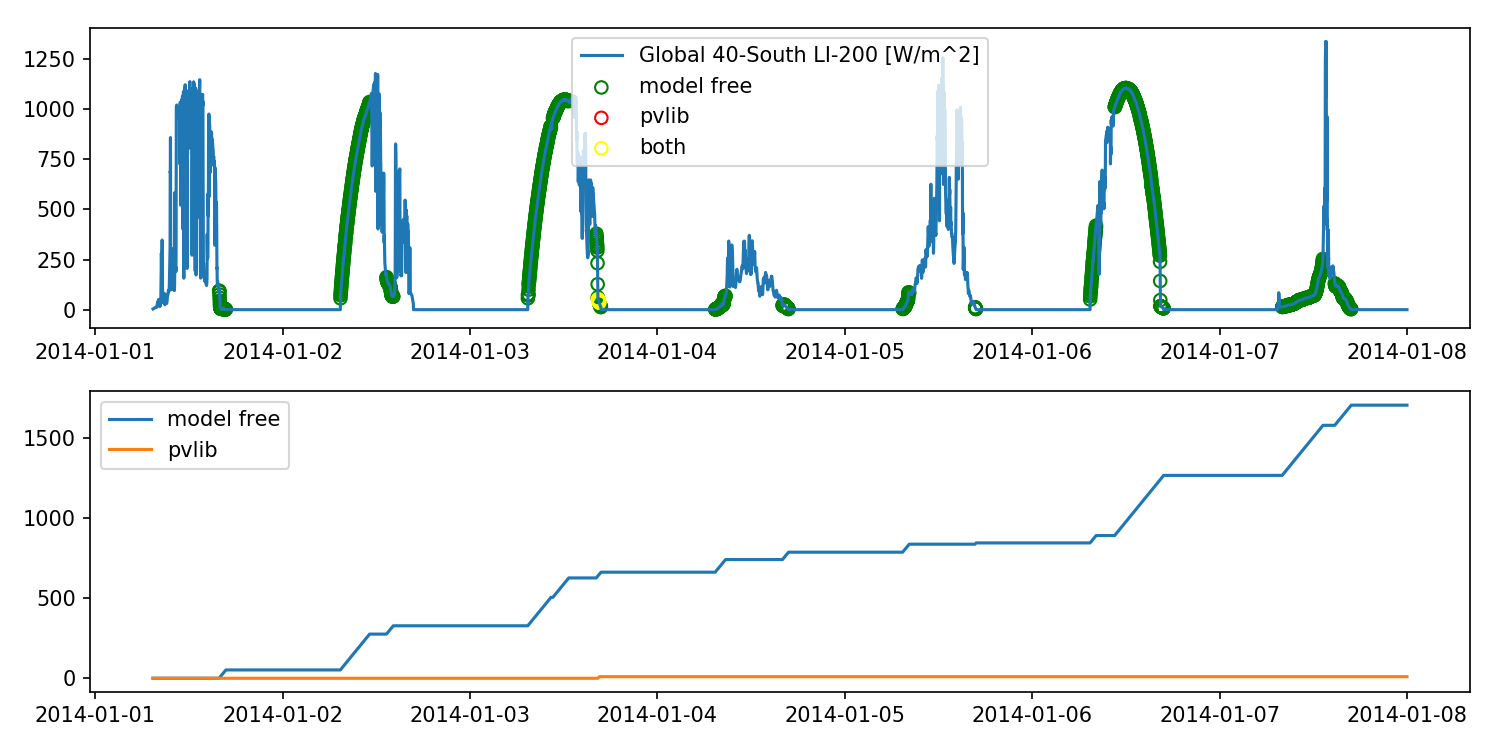

In [27]:
pvlib_compare_plot(srrl_sample, srrl_clear_skies, srrl_mf_is_clear, srrl_pvlib_is_clear)

# Conclusions

We saw the SNL results in a previous notebook, they were just repeated here for easy comparison with SRRL data.  The model free approach works much better than the PVLib approach **for the same parameters** between SNL and SRRL sites.  The PVLib method could likely be finely tuned to give much better results